# 1. Load Data
Load data from Matlab with initial processing. The k-space data is of form (lines, (spokes x partitions)), and the fft data is of shape (1, (spokes x partitions)).

In [30]:
## DATA LOADING
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
import sigpy as sp
import cupy as cp
import numpy as np
import scipy.fftpack as fftpack
from admm.utils_moco import stacked_nufft_operator,golden_angle_2d_readout, golden_angle_coords_3d, pocs, phase_based_gating, create_gates

# Load the .mat file
data = loadmat('test_data_Jan.mat')

# Access the saved variables
im_data = data['img_rshp_fixed']  
im_data_fft = data['img_fft']


# We have NumPy arrays
print(im_data.shape)
print(im_data_fft.shape)

(704, 60800)
(1, 60800)


# 2. Low-pass Filter and get respiratory signal

This low-pass filter is the Buttersworth lowpass filter, the same one that Michael used. 

Frequency resolution (df): 0.000072 Hz
dt: 0.22799999999999998
fs (sampling rate): 4.385964912280702 Hz
nyq (Nyquist freq): 2.192982456140351 Hz
cutoff: 0.25 Hz
normalized cutoff: 0.11399999999999999
(60800,)


/home/lilianae/mambaforge/envs/jointrecon_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


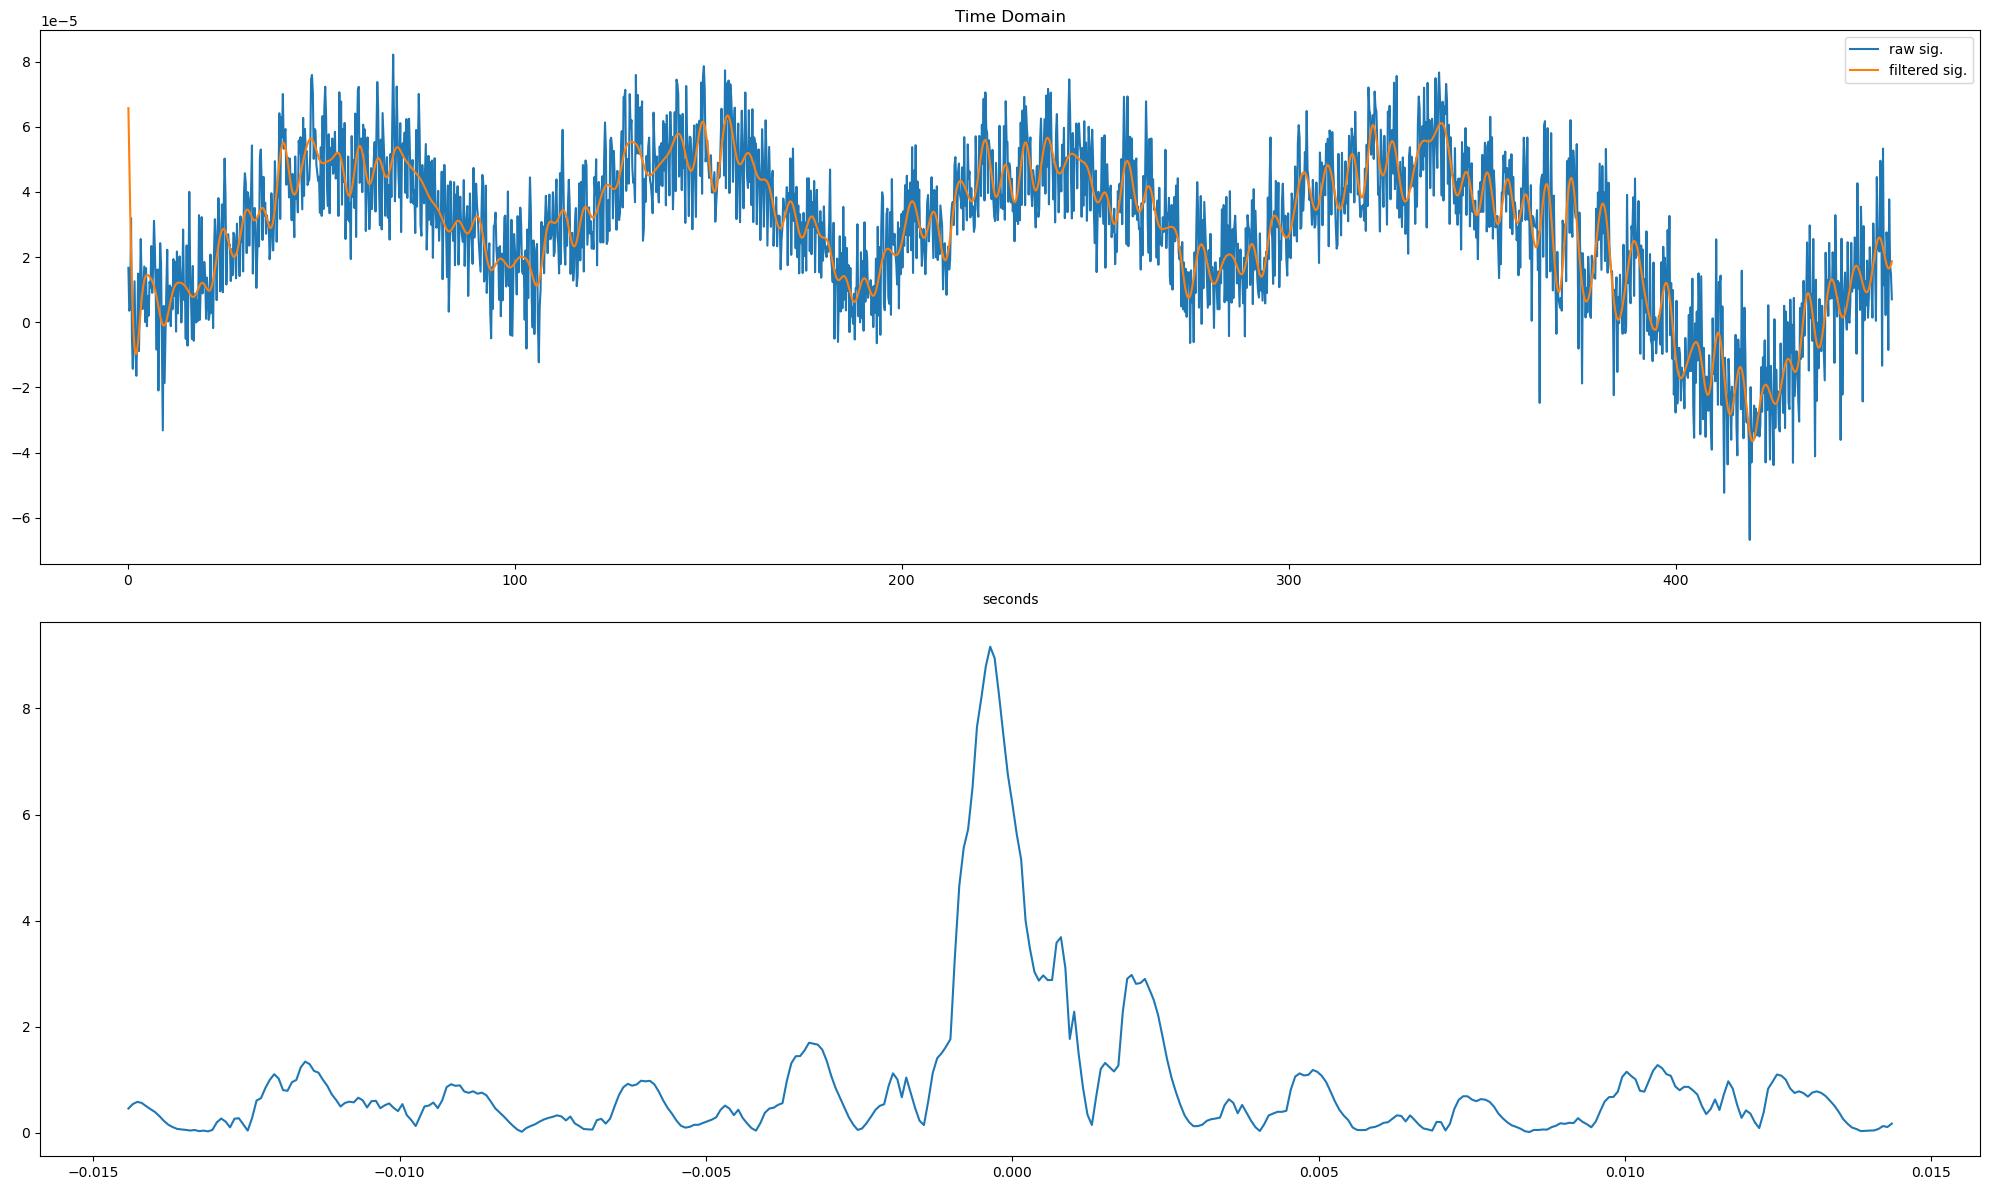

In [31]:
from scipy import signal as sig 

## Center sample (out of 704), determine from MATLAB using k-space images
center_sample = 256

## Time and Frequency resolution calculations
num_slices = 38
TR = 6.
TR_per_volume = num_slices*TR
N = len(im_data[2])
fs = 1000./TR_per_volume         # sampling rate
dt = 1/fs                       # time resolution   
df = fs/N                       # frequency resolution
f = np.linspace(-N/2, N/2, N) * df              # Used initially for plotting time

timescale = np.arange(start=0, stop=(60799*1/fs), step=dt)
cutoff = 0.25      # in Hz -> roughly 15 resp/minute
nyq = 0.5*fs

## Double check all values
print(f"Frequency resolution (df): {df:.6f} Hz")
print(f"dt: {dt}")
print(f"fs (sampling rate): {fs} Hz")
print(f"nyq (Nyquist freq): {nyq} Hz")
print(f"cutoff: {cutoff} Hz")
print(f"normalized cutoff: {cutoff/nyq}")

def butter_lowpass_filter_v2(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # More aggressive filter design
    b, a = sig.butter(order, normal_cutoff, btype='low')
    # Apply filter twice for sharper cutoff
    y = sig.filtfilt(b, a, data)
    y = sig.filtfilt(b, a, y)  # Second pass
    return y

## Plot both time and frequency domain
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
# bandwidth is going to be 1/delta t
# Try more aggressive filtering
signal_lp_flt2 = butter_lowpass_filter_v2(im_data[center_sample,:], cutoff, fs, order=4)

## Time domain plot
ax1.plot(timescale[1:2000], -im_data[center_sample,1:2000], label='raw sig.')
ax1.plot(timescale[1:2000], -signal_lp_flt2[1:2000], label='filtered sig.')
ax1.set_xlabel('seconds')
ax1.set_title('Time Domain')
ax1.legend()

## Frequency domain plot
fft_orig = np.abs(np.fft.fftshift(np.fft.fft(im_data[center_sample,:])))
fft_filt = np.abs(np.fft.fftshift(np.fft.fft(signal_lp_flt2)))
print(fft_filt.shape)

# Full-length FFT
# plt.plot(f, fft_orig, label='Original')
# plt.plot(f, fft_filt, label='Filtered')

# Clipped FFT
# Do fft of clipped signal (not sure if x-axis scaling is correct)
frequencies = np.fft.fftshift(np.fft.fftfreq(N, d=1/fs))
freq_zoomed = frequencies[30200:30600]
plt.plot(freq_zoomed, abs(fft_orig[30200:30600]))

# ax2.axvline(x=cutoff, color='r', linestyle='--', label='Cutoff freq')
# ax2.axvline(x=-cutoff, color='r', linestyle='--')
# ax2.set_xlim(-1, 1)  # Zoom in to see the cutoff region better
# ax2.set_xlabel('Frequency (Hz)')
# ax2.set_title('Frequency Domain')
# ax2.legend()

plt.tight_layout()
plt.show()


## Perform Gating
Use functions from Michael to gate the respiratory signal. For this example, we will use only two gates to speed up computation.

In [32]:
## Perform gating

from admm.utils_moco import phase_based_gating_peak_to_peak

## Function to create gates for k-space and coordinates (taken from Michael/slightly adapted for our data)
def create_gates_from_mat(ksp,coords, idx,num_gates):
    data_bins=[]
    spoke_bins=[]

    for bin in range(1,num_gates+1):
        current_kspace = ksp[:,(idx==bin).any(axis=1), :]
        data_bins.append(current_kspace)
        current_ks = coords[:,(idx==bin).any(axis=1),:,:]
        spoke_bins.append(current_ks)

    return data_bins, spoke_bins

## Gate signal based on low-pass filtered signal
num_gates = 2

y = signal_lp_flt # Expected shape: (60800, 1)

idx = phase_based_gating_peak_to_peak(y, num_gates, order=25) # Expected shape: (60800, 1)
idx = np.reshape(idx, [1600,38])   # Reshape so that we can properly index out golden_angle_coords


## Divide k-space and spoke data
num_gates=2
img_shape = (80,256,256)
num_points = im_data.shape[0]
num_spokes = 1600
coords = golden_angle_coords_3d(img_shape, num_spokes, num_points) # Output shape: (80,1600,704,3)

# Before we create gates, reshape im_data so that it can be indexed with 'idx' variable
im_data_rshp = np.reshape(im_data, [704,1600,38])
data_bins, spoke_bins = create_gates_from_mat(im_data_rshp,coords,idx,num_gates)
print("Coords shape: ", coords.shape)
print("Data shape in first bin: ", data_bins[0].shape)
print("Data shape in  second bin: ", data_bins[1].shape)
print("Spokes shape in first bin: ", spoke_bins[0].shape)
print("Spokes shape in  second bin: ", spoke_bins[1].shape)

Coords shape:  (80, 1600, 704, 3)
Data shape in first bin:  (704, 1402, 38)
Data shape in  second bin:  (704, 1381, 38)
Spokes shape in first bin:  (80, 1402, 704, 3)
Spokes shape in  second bin:  (80, 1381, 704, 3)


# 4. Simple NUFFT Reconstruction
Sanity check by trying a simple NUFFT Reconstruction on one of the gates. Currently not working with SigPy.


In [33]:
## First NUFFT Recon attempt: using 'nufft_adjoint'

## Select test gate (gate 1) and flatten to be compatible with NUFFT
kspace_data = data_bins[0]  # Output shape: (704, 1402, 38)

## For SigPy, coords should be scaled to have its range between -n_i // 2, and n_i // 2
# People online also say to scale by pi
coords_norm = coords.copy()
for i in range(3):
        max_val = img_shape[i] / 2
        coords_norm[..., i] = coords_norm[..., i] * np.pi / max_val
print(coords_norm.shape) # same size, Output size: (80, 1600, 704, 3)

## Perform NUFFT reconstruction, taken from SigPy Tutorial
img_reconstructed = sp.nufft_adjoint(kspace_data, coords_norm, img_shape)


(80, 1600, 704, 3)


ValueError: cannot reshape array of size 37506304 into shape (1,90112000)

In [ ]:
## Second NUFFT Recon attempt: using Nufft operator and LLS
    
# Flattened k-space data for NUFFT Operator
formatted_kspace = kspace_data.reshape(-1) # Output shape: (37506304,)

coords_norm = coords.copy()
for i in range(3):
        max_val = img_shape[i] / 2
        coords_norm[..., i] = coords_norm[..., i] * np.pi / max_val

print(coords_norm.shape) # will have output size: (80, 1600, 704, 3)

# Flatten for NUFFT operator
formatted_coords = coords_norm.reshape(-1,3) # Output shape: (90112000, 3)
print(formatted_coords.shape)
print(formatted_kspace.shape)

# Create NUFFT operator
nufft_op = sp.linop.NUFFT(img_shape, formatted_coords)
    
# Reconstruct using conjugate gradient
image = sp.app.LinearLeastSquares(
    A=nufft_op,
    y=formatted_kspace,
).run()

(90112000, 3)
(37506304,)


RuntimeError: Exceptions from <[80, 256, 256]x[90112000]> NUFFTAdjoint Linop>.